In [64]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import os

In [65]:
# ImageWoof2 está organizado como:
# ./imagewoof2/train/<class>/*.jpg
# ./imagewoof2/val/<class>/*.jpg
train_dir = './imagewoof2-160/train'
val_dir = './imagewoof2-160/val'

# Define a transform to normalize the data
transform = transforms.Compose([
    transforms.Resize((160, 160)),
    transforms.ToTensor(),  # Convert the image to a PyTorch tensor
    #transforms.Normalize((0.5,), (0.5,))  # Normalize the tensor with mean and std
])

train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
test_dataset  = datasets.ImageFolder(root=val_dir,   transform=transform)

print("Train samples:", len(train_dataset), "Test samples:", len(test_dataset))
print("Classes:", train_dataset.classes)


Train samples: 9025 Test samples: 3929
Classes: ['n02086240', 'n02087394', 'n02088364', 'n02089973', 'n02093754', 'n02096294', 'n02099601', 'n02105641', 'n02111889', 'n02115641']


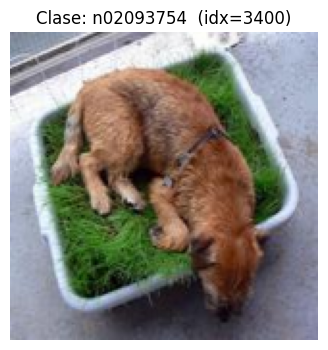

In [66]:
import random

import matplotlib.pyplot as plt

# Selecciona un índice aleatorio del conjunto de entrenamiento
idx = random.randrange(len(train_dataset))
img_tensor, lbl = train_dataset[idx]  # img_tensor: Tensor CxHxW

# Convierte a HxWxC para matplotlib
img = img_tensor.numpy().transpose(1, 2, 0)

plt.figure(figsize=(4, 4))
plt.imshow(img)
plt.title(f"Clase: {train_dataset.classes[lbl]}  (idx={idx})")
plt.axis('off')
plt.show()

In [84]:
import torch
import torch.nn as nn
from brevitas.nn import QuantConv2d, QuantReLU, QuantLinear

class QuantCNN(nn.Module):
    def __init__(self, num_classes=10, weight_bit_width=3, act_bit_width=3):
        super(QuantCNN, self).__init__()
        self.features = nn.Sequential(
            QuantConv2d(in_channels=3, out_channels=8, kernel_size=3, stride=1, padding=1, weight_bit_width=weight_bit_width),
            nn.BatchNorm2d(8),
            QuantReLU(bit_width=act_bit_width),
            nn.MaxPool2d(kernel_size=2),

            QuantConv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1, padding=1, weight_bit_width=weight_bit_width),
            nn.BatchNorm2d(16),
            QuantReLU(bit_width=act_bit_width),
            nn.MaxPool2d(kernel_size=2),

            QuantConv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1, weight_bit_width=weight_bit_width),
            nn.BatchNorm2d(32),
            QuantReLU(bit_width=act_bit_width),
            nn.MaxPool2d(kernel_size=2),

            QuantConv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1, weight_bit_width=weight_bit_width),
            nn.BatchNorm2d(64),
            QuantReLU(bit_width=act_bit_width),
            nn.MaxPool2d(kernel_size=2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            QuantLinear(64 * 10 * 10, 128, bias=True, weight_bit_width=weight_bit_width),
            nn.BatchNorm1d(128),
            QuantReLU(bit_width=act_bit_width),
            nn.Dropout(0.5),
            QuantLinear(128, num_classes, bias=True, weight_bit_width=weight_bit_width)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [68]:
from torch.utils.data import Dataset

# Define a custom quantization function
def quantize_tensor(x, num_bits=8):
    qmin = 0.
    qmax = 2.**num_bits - 1.
    min_val, max_val = x.min(), x.max()

    scale = (max_val - min_val) / (qmax - qmin)
    initial_zero_point = qmin - min_val / scale

    zero_point = 0
    if initial_zero_point < qmin:
        zero_point = qmin
    elif initial_zero_point > qmax:
        zero_point = qmax
    else:
        zero_point = initial_zero_point

    zero_point = int(zero_point)
    q_x = zero_point + x / scale
    q_x.clamp_(qmin, qmax).round_()
    
    return q_x

# Define the quantized transform
transform_quantized = transforms.Compose([
    transforms.Resize((160, 160)),
    transforms.ToTensor(),  # Convert the image to a PyTorch tensor
    transforms.Lambda(lambda x: quantize_tensor(x))  # Apply quantization
])

# Load the ImageWoof dataset with the quantized transform
train_dataset_qnt = datasets.ImageFolder(
    root=train_dir,
    transform=transform_quantized
)

test_dataset_qnt = datasets.ImageFolder(
    root=val_dir,
    transform=transform_quantized
)

train_loader = DataLoader(train_dataset_qnt, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset_qnt, batch_size=128, shuffle=False)

Min :  0.0  /// Max :  255.0
float32


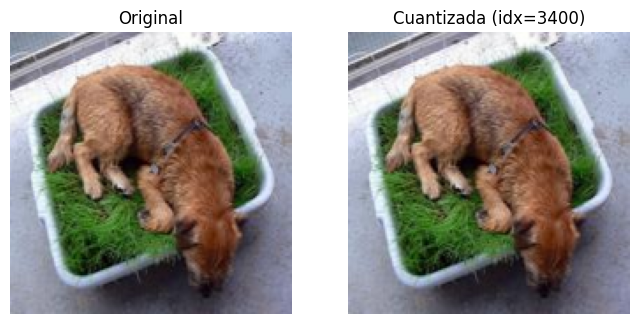

In [69]:
import matplotlib.pyplot as plt
import numpy as np

# Mostrar la imagen original y la versión cuantizada del mismo índice
sample_idx = idx if 'idx' in globals() else 0
q_tensor, q_lbl = train_dataset_qnt[sample_idx]  # C x H x W (quantized)

# Convertir a H x W x C numpy
q_np = q_tensor.numpy().transpose(1, 2, 0)

# Normalizar para visualización: si los valores >1 (ej. 0-255) escalar a 0-1
vmax = q_np.max()
if vmax > 1.0:
    q_vis = q_np / vmax
else:
    q_vis = q_np

print("Min : ", np.min(q_np), " /// Max : ", np.max(q_np))
print(q_np.dtype)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title("Original")
plt.axis("off")

plt.subplot(1, 2, 2)
# Si es imagen en escala de grises con canal único, usar cmap
if q_vis.shape[2] == 1:
    plt.imshow(q_vis.squeeze(), cmap="gray", vmin=0, vmax=1)
else:
    plt.imshow(q_vis, vmin=0, vmax=1)
plt.title(f"Cuantizada (idx={sample_idx})")
plt.axis("off")
plt.show()
     

In [85]:
# Instantiate model, criterion and optimizer properly

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# instantiate the model (use number of classes from the dataset)
brevitas_model = QuantCNN(num_classes=len(train_dataset.classes), weight_bit_width=4, act_bit_width=4)
brevitas_model = brevitas_model.to(device)

# loss criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(brevitas_model.parameters(), lr=0.001, betas=(0.9, 0.999), weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)

# compute the expected flattened feature size (robust to architecture changes)
with torch.no_grad():
    dummy = torch.zeros(1, 3, 160, 160).to(device)
    feat = brevitas_model.features(dummy)
    brevitas_input_size = feat.view(1, -1).size(1)



# use existing num_epochs if defined, otherwise default to 100
num_epochs = 10
for epoch in range(num_epochs):
    brevitas_model.train()
    running_loss = 0.0
    for batch_idx, (images, labels) in enumerate(train_loader):
        # move to device
        images = images.to(device)
        labels = labels.to(device)

        # If grayscale (1 channel), expand to 3 channels because model expects 3-channel input
        if images.size(1) == 1:
            images = images.repeat(1, 3, 1, 1)

        # ensure spatial size is 160x160 (dataset already resizes, but keep for safety)
        images = torch.nn.functional.interpolate(images, size=(160, 160), mode='bilinear', align_corners=False)

        # normalize/convert to float in [0,1] if values are in 0-255 (quantized)
        images = images.float()
        if images.max() > 1.0:
            images = images / 255.0

        # forward through the convolutional model (no manual flattening here)
        out = brevitas_model(images)
        loss = criterion(out, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')

Epoch [1/10], Loss: 2.0271
Epoch [2/10], Loss: 1.7514
Epoch [3/10], Loss: 1.6250
Epoch [4/10], Loss: 1.5130
Epoch [5/10], Loss: 1.3747
Epoch [6/10], Loss: 1.2387
Epoch [7/10], Loss: 1.0832
Epoch [8/10], Loss: 0.9632
Epoch [9/10], Loss: 0.8574
Epoch [10/10], Loss: 0.7411


In [86]:
# test the model (adaptado: pasar imágenes completas al modelo brevitas sin aplanar)
brevitas_model.eval()
correct = 0
total = 0
loss_total = 0.0

with torch.no_grad():
    for batch_idx, (images, labels) in enumerate(test_loader):
        images = images.to(device)
        labels = labels.to(device)

        # si canal único, expandir a 3 canales (el modelo espera 3 canales)
        if images.size(1) == 1:
            images = images.repeat(1, 3, 1, 1)

        # asegurar tamaño espacial 160x160
        images = torch.nn.functional.interpolate(images, size=(160, 160), mode='bilinear', align_corners=False)

        # convertir a float en [0,1] si está en 0-255
        images = images.float()
        if images.max() > 1.0:
            images = images / 255.0

        # forward completo (features + classifier) — no aplanar manualmente
        out = brevitas_model(images)
        loss = criterion(out, labels)
        loss_total += loss.item() * images.size(0)

        _, predicted = torch.max(out, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100.0 * correct / total if total > 0 else 0.0
avg_loss = loss_total / total if total > 0 else 0.0
print(f"Test Loss: {avg_loss:.4f} | Accuracy: {accuracy:.2f}% ({correct}/{total})")


Test Loss: 1.8415 | Accuracy: 40.88% (1606/3929)
